# Credit Card Default Prediction
This notebook explores and cleans the dataset, performs feature engineering, and prepares data for modeling.


In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, root_mean_squared_error

# let the notebook know where to find the data
os.chdir("C:/Users/benla/Desktop/store_sales_forecasting")



In [3]:
# first we will load the data
df_train = pd.read_csv("data/raw/train.csv", header=0)

# check out the shape and head of the dataframe
print(f"df_train shape: {df_train.shape}")
print(f"df_train head:\n{df_train.head()}")

df_train shape: (3000888, 6)
df_train head:
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0


The next step is to perform EDA on the data

In [4]:
# # check to see that there are no missing values
# print(f"missing values:\n{df_train.isnull().sum()}")


# # checking to see the general behavior of the data
# df_train.info()
# df_train.describe()


# # additional information to understand the dataset
# print('unique store numbers')
# print(df_train['store_nbr'].nunique())

# print('unique families')
# print(df_train['family'].nunique())

# print('sales averages')
# print(df_train['sales'].sum())

# print('unique dates')
# print(df_train['date'].nunique())



# df_train['date'] = pd.to_datetime(df_train['date']) # format it to the right date 
# daily_sales = df_train.groupby('date')['sales'].sum()
# daily_sales.plot(title='total sales over time') # the plot shows a relatively upward trending sales trajectory

# # see how often items get sold in general, and how often items in each family get sold.
# (df_train['sales'] == 0).mean()

# df_train.groupby('family')['sales'].apply(lambda x: (x==0).mean()).sort_values() # so it seems that there are a lot of categories that customers buy frequently and some that are not bought frequently at all


Model accuracy: 0.76
Train accuracy: 0.73
Test accuracy: 0.76
MAE: 246.59
RMSE: 663.49
R²: 0.76


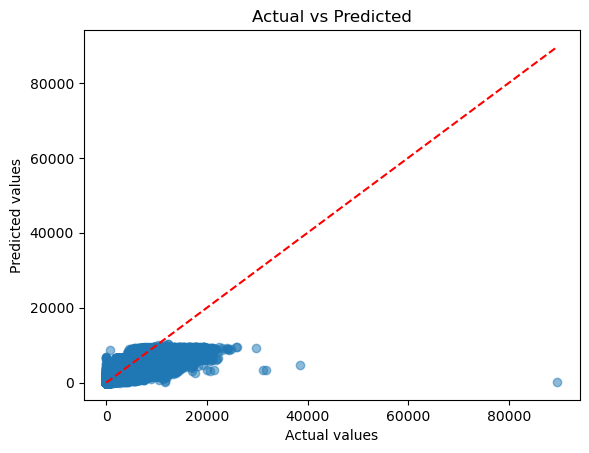

In [ ]:
# after the initial basic EDA we will make a baseline model to see how well it can fit the data
features = (col for col in df_train.columns if col not in ['sales', 'date', 'id'])
x = df_train[features]
x = pd.get_dummies(x, columns=['family'], drop_first=True)
y = df_train['sales']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=305, shuffle=False)

# now make a model

model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=305
)



model.fit(x_train, y_train)

# 🔹 5. Make predictions and evaluate
y_pred = model.predict(x_test)
accuracy = model.score(x_test, y_test)
print(f"Model accuracy: {accuracy:.2f}")

# once we have the model, we now want to evaluate it
train_acc = model.score(x_train, y_train)
test_acc = model.score(x_test, y_test)
print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")


# now move on to model evaluation

# first we just see how far awar from the actual values the model is
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}") # this is very large, given that the average sales is around 360
print(f"RMSE: {rmse:.2f}") # this is also large, which means we are getting lots of large errors
print(f"R²: {r2:.2f}")
plt.scatter(y_test, y_pred, alpha=0.5) # plot the predictions and the actual values
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# in conclusion, it seems that the variance in values of the data is very high, making MAE very large.
# Additionally, RMSE is also very large, meaning that there are many outliers
# on way of potentially combating this would be to log the sales values.
# we should also experiment with adding more features to the model, and making other models as well.

"""TODO:
1. log transform the sales values to see if it helps with the model
2. add more features to the model, such as store average sales, family average sales, etc
3. add month, day of week, and is_weekend
"""


# NEXT TIME DO RESEARCH ON THE DIFFERENT WAYS WE EVALUTATE MODELS LIKE ROC CURVES ETC.

# probably should add average store sales to the feature list

# how do i figure out which features should be added, given the context? is there something like a set checklist that can let me know if i am missing features?

# should I be adding the features first, or should i be making a really simple model first and then adding features later? how would i go about doing that? should i like add one feature at at ime, or add a bunch?

# how do i know which features are important? how do i know which features can be ignored/taken out?

# is the list of features that I should have changing with every model?


In [8]:
# now I will try to add some features to the model, and see how the performance changes
df_train['date'] = pd.to_datetime(df_train['date']) # format it to the right date
df_train['month'] = df_train['date'].dt.month
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['is_weekend'] = df_train['day_of_week'].isin([5, 6]).astype(int) # 1 if weekend, 0 if not

# also include features like store average sales, family average sales, etc
df_train['store_avg_sales'] = df_train.groupby('store_nbr')['sales'].transform('mean')

print(df_train.head())

print(df_train.info())

   id       date  store_nbr      family  sales  onpromotion  month  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0      1   
1   1 2013-01-01          1   BABY CARE    0.0            0      1   
2   2 2013-01-01          1      BEAUTY    0.0            0      1   
3   3 2013-01-01          1   BEVERAGES    0.0            0      1   
4   4 2013-01-01          1       BOOKS    0.0            0      1   

   day_of_week  is_weekend  store_avg_sales  
0            1           0       254.534889  
1            1           0       254.534889  
2            1           0       254.534889  
3            1           0       254.534889  
4            1           0       254.534889  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 10 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   date             datetime64[ns]
 2   store_nbr        int64         
 3   

Model accuracy: 0.84
Train accuracy: 0.81
Test accuracy: 0.84
MAE: 215.39
RMSE: 546.63
R²: 0.84


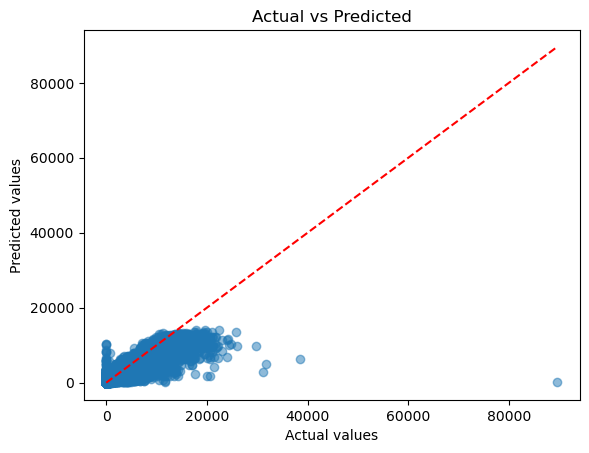

In [ ]:
# now we just basically run the same model while including the new features
features = (col for col in df_train.columns if col not in ['sales', 'date', 'id'])
x = df_train[features]
x = pd.get_dummies(x, columns=['family'], drop_first=True)
y = df_train['sales']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=305, shuffle=False)

model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=305
)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = model.score(x_test, y_test)
print(f"Model accuracy: {accuracy:.2f}")

# once we have the model, we now want to evaluate it
train_acc = model.score(x_train, y_train)
test_acc = model.score(x_test, y_test)
print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}") # this is very large, given that the average sales is around 360
print(f"RMSE: {rmse:.2f}") # this is also large, which means we are getting lots of large errors
print(f"R²: {r2:.2f}")
plt.scatter(y_test, y_pred, alpha=0.5) # plot the predictions and the actual values
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show() 